In [ ]:
!apt install poppler-utils &> /dev/null
!pip install pdf2image tqdm &> /dev/null

In [ ]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30
!pip install easyocr

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? 

In [ ]:
import pandas as pd

In [ ]:
import cv2
from ipywidgets import interact
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
from google.colab import files
import numpy as np
import easyocr
from tqdm import tqdm

In [ ]:
!wget https://msbis.parliament.go.th/ewtadmin/ewt/parliament_report/download/vote_detail/20220209190321A17.pdf -O vote.pdf

--2022-05-31 09:33:59--  https://msbis.parliament.go.th/ewtadmin/ewt/parliament_report/download/vote_detail/20220209190321A17.pdf
Resolving msbis.parliament.go.th (msbis.parliament.go.th)... 202.122.47.45
Connecting to msbis.parliament.go.th (msbis.parliament.go.th)|202.122.47.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129499 (126K) [application/pdf]
Saving to: ‘vote.pdf’

vote.pdf            100%[===================>] 126.46K   144KB/s    in 0.9s    

2022-05-31 09:34:01 (144 KB/s) - ‘vote.pdf’ saved [129499/129499]



In [ ]:
# pdf_file = files.upload()
# converted = convert_from_bytes(pdf_file['20190823113634A11.pdf'], fmt='jpg')

In [ ]:
converted = convert_from_path('/content/vote.pdf', fmt='jpg')

In [ ]:
padding = (0, 0)

In [ ]:
def add_padding(im):
  im[ :padding[1], :]            = 255
  im[-padding[1]:, :]            = 255
  im[           :, :padding[0]]  = 255
  im[           :, -padding[0]:] = 255
  return im

In [ ]:
def draw_padding(padding_x, padding_y):
  global padding
  padding = (padding_x, padding_y)
  image1 = np.array(converted[0])
  h, w, c = image1.shape
  rec = cv2.rectangle(image1, (padding_x, padding_y), (w-padding_x, h-padding_y), 0, 10)
  plt.imshow(rec)
interact(draw_padding, padding_x=120, padding_y=185);

interactive(children=(IntSlider(value=120, description='padding_x', max=360, min=-120), IntSlider(value=185, d…

In [ ]:
pages = [np.array(im) for im in converted]

# หาหลักในหน้า

In [ ]:
def detect_column(images):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
  hist_avg = None
  for im in images:
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    gray = add_padding(gray)
    th, threshed = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(threshed, kernel)
    if hist_avg is None:
      hist_avg = cv2.reduce(dilated, 0, cv2.REDUCE_AVG)
    else:
      hist_avg = (hist_avg + cv2.reduce(dilated, 0, cv2.REDUCE_AVG))/2
  hist_avg = hist_avg/len(pages)
  hist_avg = hist_avg.reshape(-1)

  lined = im.copy()
  hist_b = hist_avg < hist_avg.std()
  cols1 = np.argwhere(hist_b[1:] & (hist_b[1:] ^ hist_b[:-1])).reshape(-1)
  cols2 = np.argwhere(hist_b[:-1] & (hist_b[1:] ^ hist_b[:-1])).reshape(-1)
  cols = (cols1 + ((cols1 - cols2)*0.8)).astype(int)
  return cols

In [ ]:
columns = detect_column(pages)
columns

array([ 324,  461,  913, 1328, 1510])

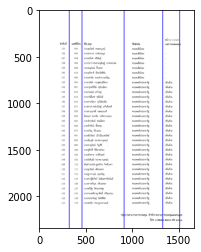

In [ ]:
show_im = pages[4].copy()
for col in columns:
  show_im = cv2.line(show_im, (col, 0), (col, show_im.shape[0]), (0, 0, 255), 5)

plt.imshow(show_im)

# หากล่องในแต่ละบรรทัด

In [ ]:
reader = easyocr.Reader(['th'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
rects_in_lines = []
log = []
for image in tqdm(pages):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  gray = add_padding(gray)
  blured = cv2.GaussianBlur(gray, (9,9), 0)
  th, threshed = cv2.threshold(blured, 200, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  threshed = cv2.dilate(threshed, kernel)
  hist = cv2.reduce(threshed, 1, cv2.REDUCE_AVG).reshape(-1)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
  dilated = cv2.dilate(threshed, kernel)
  contours, hier  = cv2.findContours(
        dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  rects = [cv2.boundingRect(c) for c in contours]
  rects.sort(key=lambda rect: rect[1])

  h,w = image.shape[:2]
  stack_y = []
  for ii in range(h-1):
    if (hist[ii] and not hist[ii+1]):
      stack_y.append(ii)
    elif (not hist[ii] and hist[ii+1]):
      stack_y.append(ii)

  line_num = len(stack_y)//2
  while(stack_y):
    rects_in_col = [[] for _ in range(len(columns)+1)]
    line_y2 = stack_y.pop(0)
    line_y1 = stack_y.pop(0)
    line_rects = []
    while rects:
      rect = rects[0]
      y_mid_point = rect[1] + rect[3]//2
      x_mid_point = rect[0] + rect[2]//2
      if line_y2 < y_mid_point < line_y1:
        rect = rects.pop(0)
        line_rects.append(rect)
      else:
        break
    line_rects.sort(key=lambda x: x[0])

    for x, y, w, h in line_rects:
      col = (x + (w/2) > columns).sum()
      text = reader.recognize(image[y:y+h, x:x+w])[0][1]
      if col >= len(rects_in_col):
        log.append((col, text))
        continue
      rects_in_col[col].append(text)
    rects_in_lines.append(rects_in_col)


100%|██████████| 15/15 [01:12<00:00,  4.83s/it]


In [ ]:
df = pd.DataFrame([[' '.join(r) for r in line ] for line in rects_in_lines])
df.to_csv('vote.csv', index=0)

# Matching row

In [1]:
import re
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [91]:
def similar(a, b):
    return SequenceMatcher(lambda x: x in ' ', a, b).ratio()

def vote_encoder(vote: str):
    '''
    1 = เห็นด้วย,
    2 = ไม่เห็นด้วย,
    3 = งดออกเสียง,
    4 = ไม่ลงคะแนนเสียง, 
    5 = ไม่เข้าร่วมประชุม,
    \- = ไม่ใช่วาระการประชุม
    '''
    if not isinstance(vote, str):
      return 5

    vote = vote.replace('.ท็น', 'เห็น').replace('เท็น', 'เห็น')

    if vote == 'เห็นด้วย':
        return 1
    if vote == 'ไม่เห็นด้วย':
        return 2
    if vote == 'งดออกเสียง':
        return 3
    if vote == 'ไม่ลงคะแนนเสียง':
        return 4
    if vote == '-':
        return 5
    p = (similar(vote, 'เห็นด้วย'), similar(vote, 'ไม่เห็นด้วย'),
         similar(vote, 'งดออกเสียง'), similar(vote, 'ไม่ลงคะแนนเสียง'))
    i = np.argmax(p)
    if p[i] < .8:
        return 5
    return i + 1

In [89]:
def fix_party(p, ps):
    if not p:
        return p
    sim_l = []
    for x in ps:
        sim = similar(p, str(x))
        if sim > .8:
            return x
        sim_l.append(sim)
    if max(sim_l) > 7:
      return ps[np.argmax(sim_l).reshape(-1)[0]]
    return p

In [101]:
df = pd.read_csv('/content/vote.csv')
df['4'] = df['4'].apply(vote_encoder)
df

,0,1,2,3,4,5
0,NaN,วันที 09 เดือน กุมภาพันธ์ พ.ศ.,2565 เวลา 18:36,ร่างพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายแพ่...,5,NaN
1,จำนานผู้เข้าร่วมประชุม,NaN,350,อณะรัฐมนตรีรับไปพิจารณาก่อนรับหลักการ,5,NaN
2,เห็นด้าย,NaN,219,NaN,5,NaN
3,ไม่เห็นด้าย,NaN,118,NaN,5,NaN
4,งดออกเสียง,NaN,12,NaN,5,NaN
...,...,...,...,...,...,...
515,เครื่องหมาย,บ,(ยัติภังค์) หมายถึง ฺผู้ไม่ลงมติ/ผู้ลาประชุม/ผ...,NaN,5,NaN
516,NaN,ยู้ปฏิบัติหน้าทีประธานในทีประชุม,NaN,NaN,5,NaN
517,นายขวน,หลีกภัย,ประธานสภาผู้แทนราษฎร,NaN,5,NaN
518,NaN,NaN,NaN,.,5,NaN


In [102]:
df = df[df['0'].apply(lambda x: str(x).strip().isdigit())
   | df['1'].apply(lambda x: str(x).strip().isdigit())
]

In [8]:
they_work_for_us_sheet_id = '1kcom8zgR-FMCGu78bCwilxq5-GrE4NVr5cE4L7geUuo'
sheet = gc.open_by_key(they_work_for_us_sheet_id)
sheet

<Spreadsheet '[WeVis] They Work for Us - Politician Data' id:1kcom8zgR-FMCGu78bCwilxq5-GrE4NVr5cE4L7geUuo>

In [9]:
rows = sheet.worksheet('[T] PeopleVote').get_all_values()
validate_df = pd.DataFrame.from_records(rows[2:], columns=rows[1])

In [92]:
worksheet = sheet.worksheet('[T] People')
rows = worksheet.get_all_values()
people_df = pd.DataFrame.from_records(rows[2:], columns=rows[1])
people_df = people_df[['id', 'name', 'lastname', 'party', 'is_mp', 'is_active']]
people_df

,id,name,lastname,party,is_mp,is_active
0,1,ประยุทธ์,จันทร์โอชา,,0,1
1,2,ประวิตร,วงษ์สุวรรณ,พลังประชารัฐ,0,1
2,3,สมคิด,จาตุศรีพิทักษ์,พลังประชารัฐ,0,0
3,4,วิษณุ,เครืองาม,,0,1
4,5,ชัยชาญ,ช้างมงคล,,0,1
...,...,...,...,...,...,...
1053,1054,ชวน,ชูจันทร์,พลังประชารัฐ,1,1
1054,1055,จักพันธ์,ปิยพรไพบูลย์,ประชาธิปัตย์,1,1
1055,1056,สุภาพร,กำเนิดผล,ประชาธิปัตย์,1,1
1056,1057,สุเนตตา,แซ่โก๊ะ,รวมพลังประชาชาติไทย,1,1


In [93]:
is_active_mp = (people_df.is_mp == '1') & (people_df.is_active == '1')

In [104]:
people_df[is_active_mp]

,id,name,lastname,party,is_mp,is_active,new_vote
21,22,กนก,ลิ้มตระกูล,เพื่อไทย,1,1,-1
22,23,กนก,วงษ์ตระหง่าน,ประชาธิปัตย์,1,1,-1
23,24,กมลศักดิ์,ลีวาเมาะ,ประชาชาติ,1,1,-1
25,26,กรณิศ,งามสุคนธ์รัตนา,พลังประชารัฐ,1,1,-1
26,27,กรวีร์,ปริศนานันทกุล,ภูมิใจไทย,1,1,-1
...,...,...,...,...,...,...,...
1053,1054,ชวน,ชูจันทร์,พลังประชารัฐ,1,1,-1
1054,1055,จักพันธ์,ปิยพรไพบูลย์,ประชาธิปัตย์,1,1,-1
1055,1056,สุภาพร,กำเนิดผล,ประชาธิปัตย์,1,1,-1
1056,1057,สุเนตตา,แซ่โก๊ะ,รวมพลังประชาชาติไทย,1,1,-1


In [105]:
df['3'] = df['3'].apply(
    lambda x: fix_party(
      str(x).replace('.', '')
      .replace(',', '')
      .replace('พรรศ', 'พรรค')
      .replace('ทรรค', 'พรรค')
      .replace('พรวศ', 'พรรค')
      .replace('พรรค', ''),
      people_df.party.unique()
      ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
df['3'].unique()

array(['เพื่อไทย', 'เพือไหย', 'พื่วไทย', 'พลังประชารัฐ', 'ภูมิใจไทย',
       'ก้าวไกล', 'ประชาธิปัตย์', 'เศรษฐกิจไทย', 'ชาติไทยพัฒนา',
       'เสรีรวมไทย', 'สรีรามไทย ', 'ประชาชาติ', 'เพื่อชาติไทย',
       'เพื่อชาติ', 'เศรษฐกิจใหม่', 'พลังท้องถิ่นไท',
       'รวมพลังประชาชาติไทย', '-', 'ต', '=', 'รักษ์ผืนป่าประเทศไทย',
       'ครูไทยเพื่อประชาชน', 'ไทยศรีวิไลย์', 'ไทรักธรรม',
       'ประชาธิปไตยใหม่', 'ประชาภิวัฒน์', 'พลเมืองไทย', 'พลังชาติไทย',
       'พลังธรรมใหม่', 'พลังปวงชนไทย'], dtype=object)

In [130]:
people_df = people_df.assign(new_vote=-1)
num_of_it = 0
title_re = r'(นาย|นาง(สาว)?|ศาสตราจารย์|(พล|พัน)?(ตำรวจ|นาวาอากาศ)?(เอก|โท|ตรี)?)'
thai_char_re = r'[^\u0E00-\u0E7F]+'
not_matched = []
for party, g in df.groupby('3'):
  ocr_names = g['2'].apply(lambda x: 
                       re.sub(title_re, '', re.sub(thai_char_re, '', x)))
  filtered = people_df[(people_df.party == party) & is_active_mp]
  for j, ocr_name in ocr_names.items():
    found = False
    index_l = []
    sim_l = []
    for i, row in filtered.iterrows():
      if people_df.loc[i, 'new_vote'] != -1: continue
      num_of_it += 1
      name = re.sub(thai_char_re, '', ''.join(row[['name', 'lastname']].values))
      if name == ocr_name or name in ocr_name:
        found = True
        people_df.loc[i, 'new_vote'] = df.loc[j]['4']
        break

      sim = similar(name, ocr_name)
      index_l.append(i)
      sim_l.append(sim)
    
    if not found and sim_l and max(sim_l) > .7:
      index_of_max = sim_l.index(max(sim_l))
      people_index_max = index_l[index_of_max]

      people_df.loc[people_index_max, 'new_vote'] = df.loc[j]['4']
      # print(ocr_name, people_df.loc[people_index_max, ['name', 'lastname']].values)
    elif not found:
      not_matched.append((j, ocr_name))


In [145]:
def name_similar(name, row):
  name = re.sub(thai_char_re, '', ''.join(row[['name', 'lastname']].values))
  return similar(name, ocr_name)

filtered = people_df[is_active_mp
            & (people_df.new_vote == -1)]

for i, ocr_name in not_matched:
  sim_sr = filtered.apply(lambda x: name_similar(ocr_name, x), axis=1)
  idx = filtered.iloc[sim_sr.argmax()].name

  people_df.loc[idx, 'new_vote'] = df.loc[i]['4']

In [150]:
match_b = (validate_df['votelog.__82']
      .replace('-', -1)
      .replace('', 5)
      .astype(int)
      .values \
    == people_df
      .new_vote
      .values)

In [152]:
(~match_b).sum()

0

In [149]:
people_df.assign(val=validate_df['votelog.__82'].replace('-', -1).replace('', 5).astype(int).values)[match_b]

,id,name,lastname,party,is_mp,is_active,new_vote,val
